This notebook segments full ECG sheets into individual leads for independent waveform extraction.

In [1]:
#1. cells and path import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

plt.rcParams["figure.figsize"] = (12, 4)

data_path = Path("/Users/rydentamura/Desktop/projects/ecg-projectdata")
train_dir = data_path / "train"

local_ids = [f.name for f in train_dir.iterdir() if f.is_dir()]
sample_id = local_ids[0]

folder = train_dir / sample_id

# Prefer clean image
pngs = sorted(folder.glob("*0001*.png"))
if len(pngs) == 0:
    pngs = sorted(folder.glob("*.png"))

img_path = pngs[0]
print("Using image:", img_path)


Using image: /Users/rydentamura/Desktop/projects/ecg-projectdata/train/1006867983/1006867983-0001.png


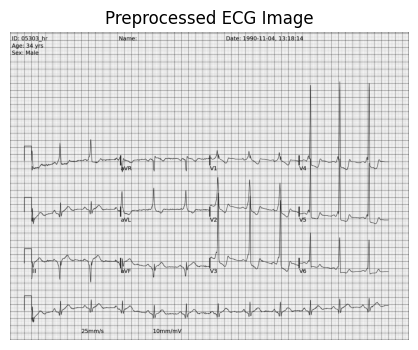

In [2]:
#2. image preprocess and load
img_bgr = cv2.imread(str(img_path))
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# Resize for consistency
target_width = 2048
aspect = gray.shape[0] / gray.shape[1]
target_height = int(target_width * aspect)
gray = cv2.resize(gray, (target_width, target_height))

# Enhance contrast
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray = clahe.apply(gray)

plt.imshow(gray, cmap="gray")
plt.title("Preprocessed ECG Image")
plt.axis("off")
plt.show()



##3.  ECG Lead Layout

Standard 12-lead ECG images are typically arranged in a 4 × 3 grid:

| Row | Leads            |
|-----|------------------|
| 1   | I, II, III       |
| 2   | aVR, aVL, aVF    |
| 3   | V1, V2, V3       |
| 4   | V4, V5, V6       |

Each cell of this grid contains the waveform for one ECG lead.
In the following steps, we assume this layout and divide the preprocessed
ECG image into 4 rows and 3 columns in order to crop out each lead region.


In [3]:
#compute grid boundaries 
H, W = gray.shape
print("Image shape:", gray.shape)

n_rows = 4
n_cols = 3

row_height = H // n_rows
col_width = W // n_cols

print("Row height:", row_height)
print("Column width:", col_width)


Image shape: (1582, 2048)
Row height: 395
Column width: 682


In [4]:
#4. crop all 12 lead regions
lead_grid = {}

lead_names = [
    ["I", "II", "III"],
    ["aVR", "aVL", "aVF"],
    ["V1", "V2", "V3"],
    ["V4", "V5", "V6"]
]

for r in range(n_rows):
    for c in range(n_cols):
        y1 = r * row_height
        y2 = (r + 1) * row_height
        x1 = c * col_width
        x2 = (c + 1) * col_width

        lead = lead_names[r][c]
        crop = gray[y1:y2, x1:x2]
        lead_grid[lead] = crop


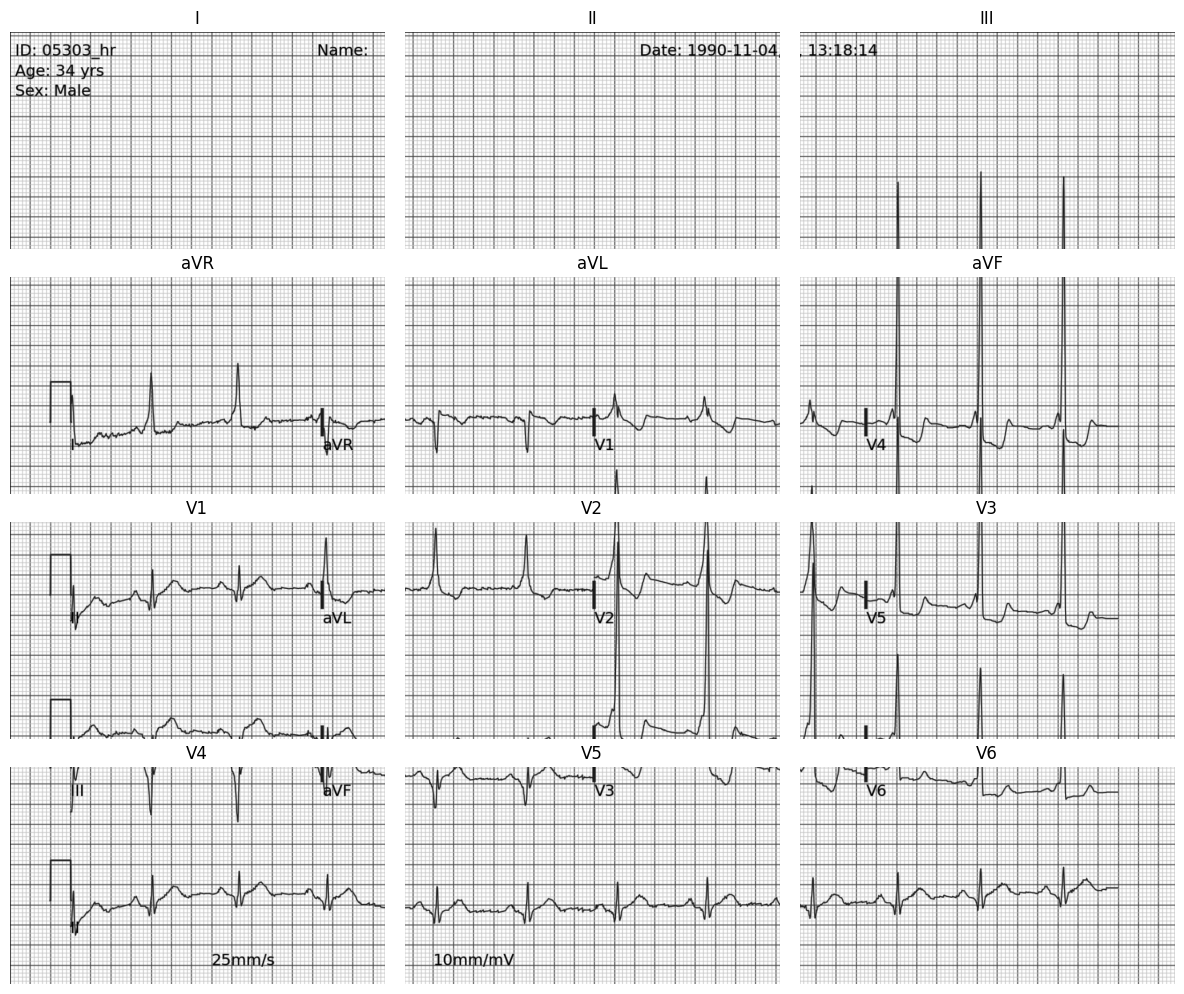

In [5]:
#5. visualize cropped leads
plt.figure(figsize=(12, 10))

i = 1
for lead, img_crop in lead_grid.items():
    plt.subplot(4, 3, i)
    plt.imshow(img_crop, cmap="gray")
    plt.title(lead)
    plt.axis("off")
    i += 1

plt.tight_layout()
plt.show()


In [6]:
#6. saved cropped elads to disk
output_dir = data_path / "cropped_leads" / sample_id
output_dir.mkdir(parents=True, exist_ok=True)

for lead, img_crop in lead_grid.items():
    out_path = output_dir / f"{lead}.png"
    cv2.imwrite(str(out_path), img_crop)

print("Saved cropped leads to:", output_dir)


Saved cropped leads to: /Users/rydentamura/Desktop/projects/ecg-projectdata/cropped_leads/1006867983
